# Latent Autoregressive Model

Using PyMC3's Autoregressive Process implementation
- API: https://docs.pymc.io/api/distributions/timeseries.html
- Example: https://docs.pymc.io/notebooks/AR.html

## Goal
Given a series of past daily counts (admissions, census, etc.) $$y_1, y_2, ..., y_T$$

Assuming $T$ is today, want to predict counts $$y_{T+1}, y_{T+2}, ..., y_{T+F}$$ for $F$ days ahead.

## Model

Suppose that $y$ is Negative Binomial distributed over the exponential of a latent time series modeled by an autoregressive process with $W$ lags, i.e., 

$$y_t \sim \text{NegBin}( \mu = \exp(f_t), \alpha )$$

where for each $t$, $f_t$ is a linear combination of the past $W$ timesteps, i.e.,

$$f_t \sim N(\mu = \beta_0 + \beta_1 * f_{t-1} + ... + \beta_W * f_{t-W}, \sigma=0.01)$$

(Use small $\sigma$ for numerical stability.)

## Parameters and their Priors

Bias weight: $$\beta_0 \sim N(0,0.1)$$
Weight on most recent timestep: $$\beta_1 \sim N(1,0.01)$$
Weights on all other previous timesteps: $$\beta_2, ..., \beta_W \sim N(0,0.01)$$

Negative Binomial dispersion parameter: $$\alpha \sim \text{TruncatedNormal}(50, 50)$$

## Hyperparameters

Window size $$W = [1,2,3,4,5,6,7,8]$$

## Training

Let's use the subscript "past" to refer to indices $1$ through $T$, and the subscript "future" for indices $T+1$ through $T+F$.

1. Define $f$ as an AR process in PyMC3. Set `rho` to be [$\beta_0, \beta_1, ..., \beta_W$]. Set `shape` to be $T+F$ so that it encompasses both $f_\text{past}$ and $f_\text{future}$.
1. Define the observed variable $$y_\text{past} \sim \text{NegBin}(\mu = \exp(f_\text{past}), \alpha)$$ Set `mu` to be the exponential of the first $T$ $f$ values, i.e., only $f_\text{past}$.
1. Use PyMC3's MCMC to draw samples from the posterior $$\alpha^s, \beta^s, f^s \sim p(\alpha, \beta, f_\text{past}, f_\text{future} | y_\text{past})$$

In [55]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano.tensor as tt

In [56]:
df = pd.read_csv("../Middlesex.csv")
y = df['cases'].astype(float)
T = len(y)

In [57]:
W = 4
F = 7

with pm.Model() as model:
    bias = pm.Normal('beta[0]', mu=0, sigma=0.1)
    beta_recent = pm.Normal('beta[1]', mu=1, sigma=0.01)
    rho = [bias, beta_recent]
    for i in range(2, W+1):
        beta = pm.Normal(f'beta[{i}]', mu=0, sigma=0.01)
        rho.append(beta)
    f = pm.AR('f', rho, sigma=0.01, constant=True, shape=T+F)
    
    alpha = pm.TruncatedNormal('alpha', mu=50, sigma=50, lower=0)
    y_past = pm.NegativeBinomial('y_past', mu=tt.exp(f[:T]), alpha=alpha, observed=y)

In [58]:
with model:
    trace = pm.sample(5000, tune=1000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, f, beta[4], beta[3], beta[2], beta[1], beta[0]]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [08:01<00:00, 49.83draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [59]:
summary = pm.summary(trace)['mean'].to_dict()
for i in range(W+1):
    print(f'beta[{i}]', summary[f'beta[{i}]'])

beta[0] 0.24
beta[1] 0.999
beta[2] -0.002
beta[3] -0.004
beta[4] -0.006


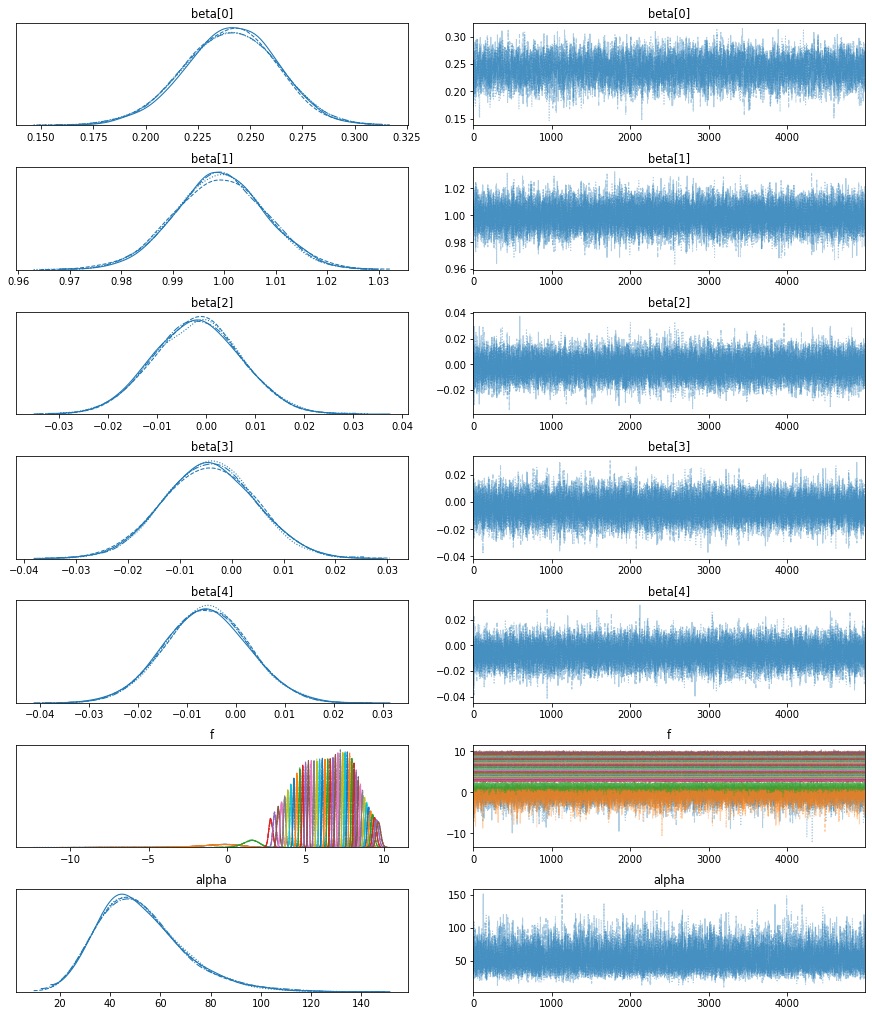

In [60]:
pm.traceplot(trace);

## Forecasting Procedure

1. Define a predictive distribution $$y_\text{future} \sim \text{NegBin}(\mu=\exp(f_\text{future}), \alpha=\alpha)$$
1. Use PyMC3's `sample_posterior_predictive` and the posterior samples collected during training to produce forecasts.
    - Note: It is not recommended to modify the number of `samples` as if it is too small, some chains may not be represented in the posterior predictive sample. Defaults to one posterior predictive sample per posterior sample, that is, the number of draws times the number of chains.

In [43]:
with model:
    y_future = pm.NegativeBinomial('y_future', mu=tt.exp(f[-F:]), alpha=alpha, shape=F)
    forecasts = pm.sample_posterior_predictive(trace, vars=[y_future], random_seed=42)
    
samples = forecasts['y_future']

100%|██████████| 4000/4000 [00:02<00:00, 1731.12it/s]


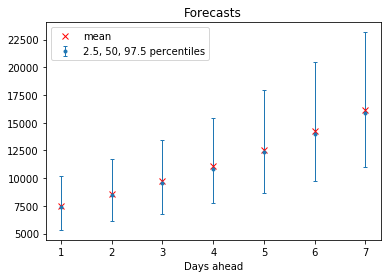

In [44]:
low = np.zeros(F)
high = np.zeros(F)
mean = np.zeros(F)
median = np.zeros(F)

for i in range(F):
    low[i] = np.percentile(samples[:,i], 2.5)
    high[i] = np.percentile(samples[:,i], 97.5)
    median[i] = np.percentile(samples[:,i], 50)
    mean[i] = np.mean(samples[:,i])

xticks = np.arange(1,F+1)
plt.errorbar(xticks, median,
             yerr=[median-low, high-median],
             capsize=2, fmt='.', linewidth=1,
             label='2.5, 50, 97.5 percentiles');
plt.plot(xticks, mean, 'rx', label='mean');
plt.legend();
plt.title('Forecasts');
plt.xlabel('Days ahead');

## Heldout Scoring Procedure

1. Partition the data to treat the first 80% as $y_\text{past}$ and the last 20% as $y_\text{future}$. We'll use $y_\text{past}$ as the training set, and $y_\text{future}$ as the validation set.
1. Train the model using $y_\text{past}$.
1. Define the predictive distribution $$y_\text{future} \sim \text{NegBin}(\mu = \exp(f_\text{future}), \alpha)$$ Set `observed` to be the observed $y_\text{future}$ values.
1. For each posterior sample {$f^s, \alpha^s, \beta^s$}, compute the log probability of the observed $y_\text{future}$. Then use Monte Carlo integration: $$\log p(y_\text{future} | y_\text{past}) = \log \frac{1}{S} \sum_{s=1}^S p(y_\text{future} | f^s, \alpha^s, \beta^s, y_\text{past})$$

In this notebook example, I'm running 10 chains in order to show that the sampler really converges. We want to see that our heldout scoring method gives similar results for all chains. In practice, we wouldn't need to sample this many chains.

In [45]:
df = pd.read_csv('../Middlesex.csv')
y = df['cases'].astype(float)

T = int(.8 * len(y))
y_tr = y[:T]
y_va = y[T:]
F = len(y_va)

In [46]:
W = 4

with pm.Model() as model:
    bias = pm.Normal('beta[0]', mu=0, sigma=0.1)
    beta_recent = pm.Normal('beta[1]', mu=1, sigma=0.01)
    rho = [bias, beta_recent]
    for i in range(2, W+1):
        beta = pm.Normal(f'beta[{i}]', mu=0, sigma=0.01)
        rho.append(beta)
    f = pm.AR('f', rho, sigma=0.01, constant=True, shape=T+F)
    
    alpha = pm.TruncatedNormal('alpha', mu=50, sigma=50, lower=0)
    y_past = pm.NegativeBinomial('y_past', mu=tt.exp(f[:T]), alpha=alpha, observed=y_tr)

In [47]:
with model:
    trace = pm.sample(5000, tune=1000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, f, beta[4], beta[3], beta[2], beta[1], beta[0]]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [06:30<00:00, 61.39draws/s]


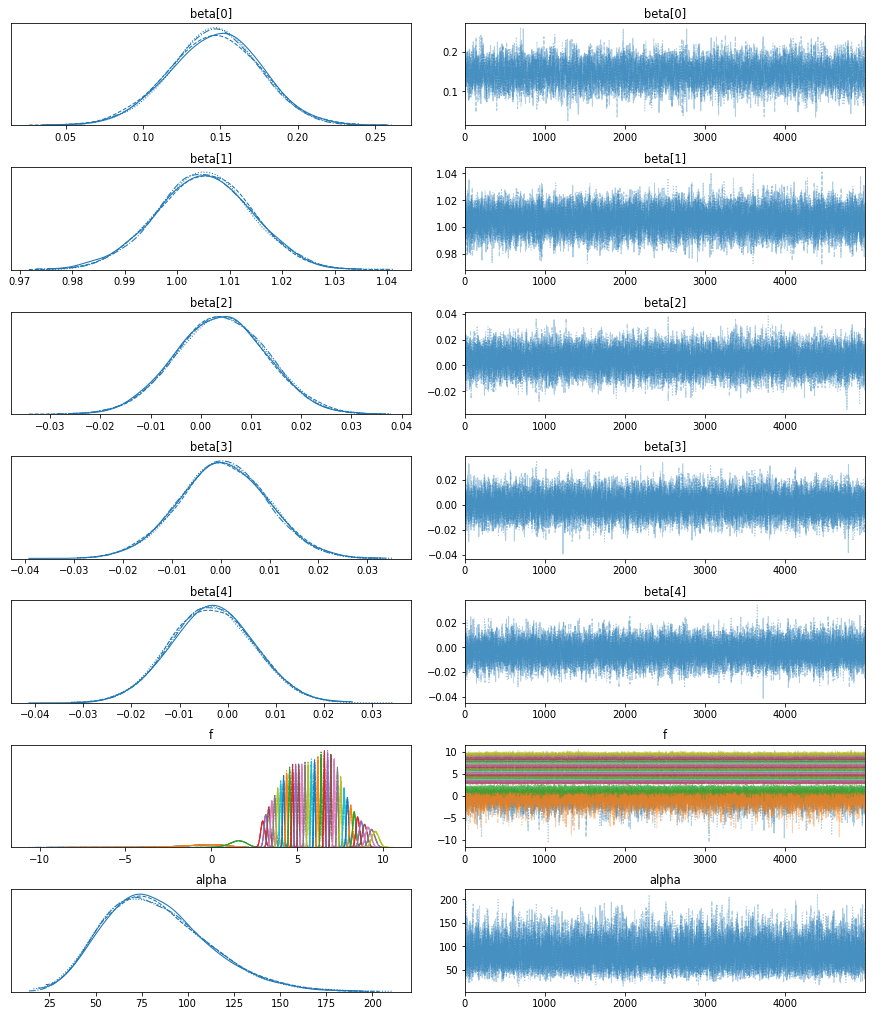

In [48]:
pm.traceplot(trace);

In [49]:
with model:
    y_future = pm.NegativeBinomial('y_future', mu=tt.exp(f[T:]), alpha=alpha, observed=y_va)

In [50]:
for chain in range(4):
    logp_list = np.zeros(len(trace))
    for i in range(len(trace)):
        logp_list[i] = y_future.logp(trace.point(i, chain=chain))
    
    score = np.log(np.mean(np.exp(logp_list))) / F
    print(f'\nChain {chain}: Heldout log likelihood = {score}\n')


Chain 0: Heldout log likelihood = -9.164730958881357


Chain 1: Heldout log likelihood = -8.707826271883825


Chain 2: Heldout log likelihood = -8.687714862212149


Chain 3: Heldout log likelihood = -8.364904249229385



## Handling missing data

If we replace one of our observed counts with NaN, PyMC3 will automatically impute the missing value from the posterior distribution.

In [51]:
df = pd.read_csv("../Middlesex.csv")
y = df['cases'].astype(float)
T = len(y)

y[10] = np.nan

In [52]:
W = 4
F = 7

with pm.Model() as model:
    bias = pm.Normal('beta[0]', mu=0, sigma=0.1)
    beta_recent = pm.Normal('beta[1]', mu=1, sigma=0.01)
    rho = [bias, beta_recent]
    for i in range(2, W+1):
        beta = pm.Normal(f'beta[{i}]', mu=0, sigma=0.01)
        rho.append(beta)
    f = pm.AR('f', rho, sigma=0.01, constant=True, shape=T+F)
    
    alpha = pm.TruncatedNormal('alpha', mu=50, sigma=50, lower=0)
    y_past = pm.NegativeBinomial('y_past', mu=tt.exp(f[:T]), alpha=alpha, observed=y)

/Users/allylee/miniconda3/envs/spr_2020s_env/lib/python3.8/site-packages/pymc3/model.py:1430: ImputationWarning: Data in y_past contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [53]:
with model:
    trace = pm.sample(5000, tune=1000, random_seed=42)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha, f, beta[4], beta[3], beta[2], beta[1], beta[0]]
>Metropolis: [y_past_missing]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [07:42<00:00, 51.87draws/s]
The number of effective samples is smaller than 25% for some parameters.


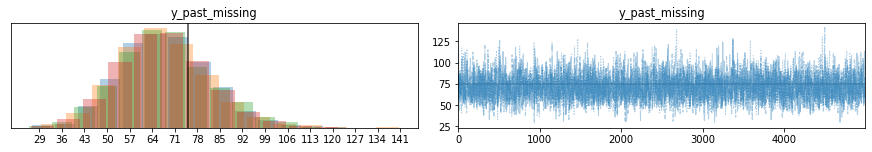

In [54]:
pm.traceplot(trace, var_names='y_past_missing', lines=(('y_past_missing',{},75),));